In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.rnn as rnn
import matplotlib.pyplot as plt

于之前的网络结构相反，个人觉得RNN在使用TF实现上比理论要难一点。原因有两个，一是RNN所用数据的维度比普通网络要高一维，即多了个时间维度；二是TF关于RNN的API不太熟，看文档不知所云。普通网络的输入数据维度为$(n_{samples},n_{features})$，而RNN的数据维度为：$(n_{samples},t_{size},n_{features})$。所以对应的数据类需要创建正确维度的数据。

另外一点就是序列的时间窗口之间不重叠，如序列$[1,2,3,4,5]$，如果选取$t\_size=2$，那么对应的$X$为：$[[1,2],[3,4]]$，$Y$为$[[3],[5]]$。

In [2]:
class SeqData1D:
    def __init__(self, seq, t_size=5, batch_size=32, normalize=False, shuffle=False):
        '''
        paths: 文件路径
        '''
        self._data = list()
        self._target = list()
        self._n_samples = 0

        self._idx = 0    # mini-batch的游标
        self._batch_size = batch_size

        self._load(seq)

        if shuffle:
            self._shuffle_data()
        if normalize:
            self._normalize_data()

        print(self._data.shape, self._target.shape)

    def _load(self, seq):
        '''
        载入数据
        '''
        n_windows = len(seq)//t_size    # 无重叠的窗口数
        X = [seq[i*t_size:(i+1)*t_size] for i in range(n_windows)]
        Y = [seq[(i+1)*t_size] for i in range(n_windows)]

        # RNN的输入数据维度应为(n_samples,t_size,n_features)
        self._data = np.reshape(X, (-1, t_size, 1))

        # target维度(n_samples,n_outputs)
        self._target = np.reshape(Y, (-1, 1))

        self._n_samples = self._data.shape[0]

    def _shuffle_data(self):
        '''
        打乱数据
        '''
        idxs = np.random.permutation(self._n_samples)
        self._data = self._data[idxs]
        self._target = self._target[idxs]

    def _normalize_data(self):
        scaler = StandardScaler()
        self._data = scaler.fit_transform(self._data)

    def next_batch(self):
        '''
        生成mini-batch
        '''
        while self._idx < self._n_samples:
            yield self._data[self._idx: (self._idx+self._batch_size)], self._target[self._idx: (self._idx+self._batch_size)]
            self._idx += self._batch_size

        self._idx = 0
        self._shuffle_data()

In [3]:
t_size = 5
batch_size = 32

seq = np.sin(np.linspace(0, 20*2*np.pi, 1002))    # 100个周期采样1002个点，1002只是为了便于分割
train_data = SeqData1D(seq[:801], t_size=t_size, batch_size=batch_size)
test_data = SeqData1D(seq[801:], t_size=t_size, batch_size=batch_size)

(160, 5, 1) (160, 1)
(40, 5, 1) (40, 1)


# 网络设计

In [4]:
unit_I = 1    # 单特征
unit_h = 64
unit_O = 1    # 单输出

# 搭建网络
这里针对TensorFlow的```tf.nn.dynamic_rnn```做一下额外说明，官方文档[见此](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)。该函数有两个返回值：```outputs```和```state```，前者包含整个时间线的状态$(h_{0},h_{2},...,h_{t})$，而后者只包含最后时刻的状态，若RNN单元为GRU，则为$h_{t}$；若RNN单元为LSTM，则为$(c_{t},h_{t})$。一般在模型中需要用到的数据就是各时间的输出$h$，所以返回值```state```很少用。

```outputs```的默认维度为```(batch_size,t_size,hidden_size)```，而```state```的维度根据RNN单元的不同而有两种：GRU为```(batch_size,hidden_size)```，LSTM为```(2,batch_size,hidden_size)```。

In [5]:
X = tf.placeholder(tf.float32, [None, t_size, unit_I])
Y = tf.placeholder(tf.float32, [None, unit_O])

with tf.name_scope('LSTM'):
    lstm_cell = tf.nn.rnn_cell.LSTMCell(unit_h)
    outputs, _ = tf.nn.dynamic_rnn(lstm_cell, inputs=X, dtype=tf.float32)

    # outputs[:, -1, :]即最后时刻的输出h(t)
    pred = tf.layers.dense(outputs[:, -1, :], unit_O, activation=None)

with tf.name_scope('Eval'):
    loss = tf.losses.mean_squared_error(labels=Y, predictions=pred)

with tf.name_scope('train_op'):
    lr = 1e-3
    train_op = tf.train.RMSPropOptimizer(lr).minimize(loss)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True    # 按需使用显存

W0717 17:16:05.186419  2576 deprecation.py:323] From <ipython-input-5-70fade6fe5be>:5: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0717 17:16:05.188401  2576 deprecation.py:323] From <ipython-input-5-70fade6fe5be>:7: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W0717 17:16:05.189404  2576 deprecation.py:323] From <ipython-input-5-70fade6fe5be>:10: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0717 17:16:05.271377  2576 deprecation.p

# 训练网络

In [6]:
with tf.Session(config=config) as sess:
    sess.run(init)
    epochs = 100

    batch_cnt = 0
    for epoch in range(epochs):
        for batch_data, batch_labels in train_data.next_batch():
            batch_cnt += 1
            loss_val, _ = sess.run([loss, train_op],
                                   feed_dict={X: batch_data,
                                              Y: batch_labels})

            # 每1000batch输出一次信息
            if (batch_cnt+1) % 100 == 0:
                print('epoch: {}, batch_loss: {}'
                      .format(epoch+1, loss_val))

            # 每5000batch做一次验证
            if (batch_cnt+1) % 500 == 0:
                all_test_acc_val = list()
                for test_batch_data, test_batch_labels in test_data.next_batch():
                    test_acc_val = sess.run(loss,
                                            feed_dict={X: test_batch_data,
                                                       Y: test_batch_labels})
                    all_test_acc_val.append(test_acc_val)
                test_acc = np.mean(all_test_acc_val)
                print('epoch: {}, test_loss: {}'.format(epoch+1, test_acc))

    X_test = np.array([])
    Y_test = np.array([])
    Y_pred = np.array([])
    for test_batch_data, test_batch_labels in test_data.next_batch():
        X_test = np.append(X_test, test_batch_data)
        Y_test = np.append(Y_test, test_batch_labels)
        Y_pred = np.append(Y_pred, sess.run(pred,
                                            feed_dict={X: test_batch_data, Y: test_batch_labels}))

epoch: 20, batch_loss: 0.08662862330675125
epoch: 40, batch_loss: 0.027187995612621307
epoch: 60, batch_loss: 0.00023899106599856168
epoch: 80, batch_loss: 0.00011962976714130491
epoch: 100, batch_loss: 0.0014950366457924247
epoch: 100, test_loss: 0.0004896112950518727


<Figure size 432x288 with 0 Axes>

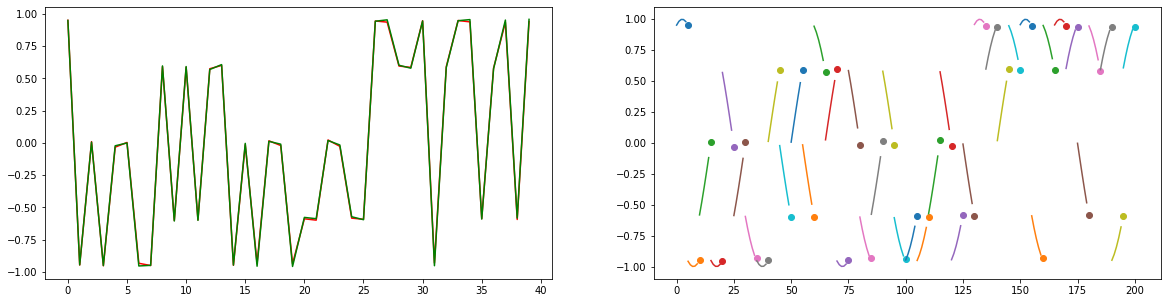

In [7]:
import matplotlib.pyplot as plt
plt.clf()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(Y_pred, c='r')
axs[0].plot(Y_test, c='g')

for idx in range(len(Y_pred)):    # 因为测试样本是打乱的，只能以时间窗口为单位绘制
    axs[1].plot(range(idx*5, (idx+1)*5), X_test[idx*5:(idx+1)*5])
    axs[1].scatter((idx+1)*5, Y_pred[idx])

plt.show()

In [8]:
# def gen_lstm_layer(inputs, unit_I, unit_O, t_size=5, batch_size=32, init=tf.random_uniform_initializer(-1, 1)):
#     '''
#     生成一层LSTM
#     inputs: 序列数据，维度为(n_samples,t_size,n_features)，也可为(n_samples,t_size)
#     '''
#     def gen_params(unit_I, unit_O):
#         '''
#         生成权重与偏置参数
#         '''
#         w_x = tf.get_variable([unit_I, unit_O], name='w_x')
#         w_h = tf.get_variable([unit_O, unit_O], name='w_x')
#         b = tf.get_variable([1, unit_O], name='bias',
#                             initializer=tf.constant_initializer(0.0))
#         return w_x, w_h, b

#     with tf.variable_scope('LSTM_layer', initializer=init):
#         with tf.variable_scope('i'):
#             w_ix, w_ih, b_i = gen_params(unit_I, unit_O)
#         with tf.variable_scope('f'):
#             w_fx, w_fh, b_f = gen_params(unit_I, unit_O)
#         with tf.variable_scope('g'):
#             w_gx, w_gh, b_g = gen_params(unit_I, unit_O)
#         with tf.variable_scope('o'):
#             w_ox, w_oh, b_o = gen_params(unit_I, unit_O)

#         # 初始的c与h，零初始化
#         c = tf.Variable(tf.zeros([batch_size, unit_O]), trainable=False)
#         h = tf.Variable(tf.zeros([batch_size, unit_O]), trainable=False)

#         for t in range(t_size):
#             input_t = inputs[:, i, :]    # 提取时间维度
#             input_t = tf.reshape(input_t, [batch_size, unit_I])

#             f = tf.sigmoid(tf.matmul(input_t, w_fx)+tf.matmul(h, w_fh)+b_f)
#             i = tf.sigmoid(tf.matmul(input_t, w_ix)+tf.matmul(h, w_ih)+b_i)
#             g = tf.tanh(tf.matmul(input_t, w_gx)+tf.matmul(h, w_gh)+b_g)
#             o = tf.sigmoid(tf.matmul(input_t, w_ox)+tf.matmul(h, w_oh)+b_o)

#             c = c*f+g*i
#             h = o*tf.tanh(c)
            
#         return h